## NeurIPS attention heads visualization

**Purpose:** Visualization of attention heads for SMT models trained on full dataset

**Associated Figures:** Fig. 13

**Author:** Alexander Ratzan    
**Project:** Predicting Functional Brain Connectivity with Context-Aware Deep Neural Networks (NeurIPS 2025)

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-05-29 18:23:44.018751: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 18:23:45.515148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-29 18:23:47.659152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib as npm

  au

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn
absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn


<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 4.5%
RAM Usage: 4.4%
Available RAM: 962.7G
Total RAM: 1007.0G
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA A100-SXM4-80GB - Memory Allocated: 0.00 GB


In [19]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()

# if a number is seen a GPU is available
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

XGBoost version: 2.0.3
cupy version: 13.1.0
GPU found 0
| ID | GPU | MEM |
------------------
|  0 | 11% |  1% |


In [20]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Attention heads analysis

In [21]:
from models.base_models import ModelBuild, BaseModel
from models.bilinear import BilinearLowRank, BilinearCM
from models.pls import PLSTwoStepModel, PLS_MLPDecoderModel, PLS_BilinearDecoderModel
from models.dynamic_mlp import DynamicMLP
from models.shared_encoder_models import SharedMLPEncoderModel, SharedLinearEncoderModel
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel, CrossAttentionModel

from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

### Load UKBB data and models

In [24]:
# Load data
print("Loading data...")
X_UKBB = load_transcriptome(parcellation='S400', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y_UKBB = load_connectome(parcellation='S400', hemisphere='both', omit_subcortical=False)
coords_UKBB = load_coords(parcellation='S400', hemisphere='both', omit_subcortical=False)
labels_UKBB, network_labels_UKBB = load_network_labels(parcellation='S400', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices_UKBB = ~np.isnan(X_UKBB).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values_UKBB = np.where(valid_indices_UKBB)[0]
valid2true_mapping_UKBB = dict(enumerate(valid_indices_values_UKBB))

# Subset all data using valid indices
X_UKBB_valid = X_UKBB[valid_indices_UKBB]
Y_UKBB_valid = Y_UKBB[valid_indices_UKBB][:, valid_indices_UKBB]
coords_UKBB_valid = coords_UKBB[valid_indices_UKBB]
labels_UKBB = [labels_UKBB[i] for i in range(len(labels_UKBB)) if valid_indices_UKBB[i]]
network_labels_UKBB = network_labels_UKBB[valid_indices_UKBB]

print(f"X_UKBB_valid shape: {X_UKBB_valid.shape}")

# Create full region pair dataset
print("Creating RegionPairDataset...")
dataset_UKBB = RegionPairDataset(
    X=X_UKBB_valid,
    Y=Y_UKBB_valid,
    coords=coords_UKBB_valid,
    valid2true_mapping=valid2true_mapping_UKBB
)

batch_size = 512
# Create dataloader with all pairs
dataloader_UKBB = DataLoader(
    dataset_UKBB,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True  # Speed up data transfer to GPU
)

# Set up regular self-attention model with same hyperparameters
smt_UKBB_model = SharedSelfAttentionModel(
    input_dim=14760,
    token_encoder_dim=60, 
    d_model=128,
    nhead=4,
    num_layers=4,
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
smt_UKBB_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_base.pt"))
smt_UKBB_model.eval()
smt_UKBB_model.to("cuda")

# Set up CLS model with the same hyperparameters used for training
smt_cls_UKBB_model = SharedSelfAttentionCLSModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    cls_init='spatial_learned',
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved CLS weights
smt_cls_UKBB_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_cls.pt"))
smt_cls_UKBB_model.eval()
smt_cls_UKBB_model.to("cuda")

Loading data...
X_UKBB_valid shape: (455, 7380)
Creating RegionPairDataset...


  warnings.warn(



Number of learnable parameters in SMT model: 1399947
Number of learnable parameters in SMT w/ CLS model: 1405579


SharedSelfAttentionCLSModel(
  (encoder): OptimizedModule(
    (_orig_mod): SelfAttentionCLSEncoder(
      (input_projection): Linear(in_features=60, out_features=128, bias=True)
      (coord_to_cls): Linear(in_features=3, out_features=128, bias=True)
      (layers): ModuleList(
        (0-3): 4 x FastSelfAttentionBlock(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
            (3): Dropout(p=0.2, inplace=False)
          )
          (ffn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (output_projection): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (deep_layers): Sequential(
    (

In [25]:
# Load data
print("Loading data...")
X_iPA391 = load_transcriptome(parcellation='iPA_391', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y_iPA391 = load_connectome(parcellation='iPA_391', hemisphere='both', omit_subcortical=False)
coords_iPA391 = load_coords(parcellation='iPA_391', hemisphere='both', omit_subcortical=False)
labels_iPA391, network_labels_iPA391 = load_network_labels(parcellation='iPA_391', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices_iPA391 = ~np.isnan(X_iPA391).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values_iPA391 = np.where(valid_indices_iPA391)[0]
valid2true_mapping_iPA391 = dict(enumerate(valid_indices_values_iPA391))

# Subset all data using valid indices
X_iPA391_valid = X_iPA391[valid_indices_iPA391]
Y_iPA391_valid = Y_iPA391[valid_indices_iPA391][:, valid_indices_iPA391]
coords_iPA391_valid = coords_iPA391[valid_indices_iPA391]
labels_iPA391 = [labels_iPA391[i] for i in range(len(labels_iPA391)) if valid_indices_iPA391[i]]
network_labels_iPA391 = network_labels_iPA391[valid_indices_iPA391]

print(f"X_iPA391_valid shape: {X_iPA391_valid.shape}")

# Create full region pair dataset
print("Creating RegionPairDataset...")
dataset_iPA391 = RegionPairDataset(
    X=X_iPA391_valid,
    Y=Y_iPA391_valid,
    coords=coords_iPA391_valid,
    valid2true_mapping=valid2true_mapping_iPA391
)

batch_size = 512
# Create dataloader with all pairs
dataloader_iPA391 = DataLoader(
    dataset_iPA391,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True  # Speed up data transfer to GPU
)

# Set up regular self-attention model with same hyperparameters
smt_iPA391_model = SharedSelfAttentionModel(
    input_dim=14760,
    token_encoder_dim=60, 
    d_model=128,
    nhead=4,
    num_layers=4,
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
smt_iPA391_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/iPA391_base.pt"))
smt_iPA391_model.eval()
smt_iPA391_model.to("cuda")

# Set up CLS model with the same hyperparameters used for training
smt_cls_iPA391_model = SharedSelfAttentionCLSModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    cls_init='spatial_learned',
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved CLS weights
smt_cls_iPA391_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/iPA391_cls.pt"))
smt_cls_iPA391_model.eval()
smt_cls_iPA391_model.to("cuda")

Loading data...
X_iPA391_valid shape: (345, 7380)
Creating RegionPairDataset...


  warnings.warn(



Number of learnable parameters in SMT model: 1399947
Number of learnable parameters in SMT w/ CLS model: 1405579


SharedSelfAttentionCLSModel(
  (encoder): OptimizedModule(
    (_orig_mod): SelfAttentionCLSEncoder(
      (input_projection): Linear(in_features=60, out_features=128, bias=True)
      (coord_to_cls): Linear(in_features=3, out_features=128, bias=True)
      (layers): ModuleList(
        (0-3): 4 x FastSelfAttentionBlock(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
            (3): Dropout(p=0.2, inplace=False)
          )
          (ffn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (output_projection): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (deep_layers): Sequential(
    (

### Evaluate attention heads

Map gene tokens to corresponding genes

In [26]:
# Get valid genes from load_transcriptome
X, valid_genes = load_transcriptome(parcellation='S400', gene_list='0.2', dataset='AHBA', run_PCA=False, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='refgenome', return_valid_genes=True, null_model='none', random_seed=42)

# Get reference genome info for valid genes
refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')
valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)]

# Create gene groups/tokens
token_chunk_size = 60
num_tokens = len(valid_refgenome) // token_chunk_size
gene_tokens = []

for i in range(num_tokens):
    start_idx = i * token_chunk_size
    end_idx = start_idx + token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:end_idx]
    
    # Get unique chromosome for this token
    chrom = token_genes['chromosome'].iloc[0]
    
    token = {
        'token_id': i,
        'genes': token_genes['gene_id'].tolist(),
        'chromosome': chrom
    }
    gene_tokens.append(token)

# Handle remaining genes if any
remaining_genes = len(valid_refgenome) % token_chunk_size
if remaining_genes > 0:
    start_idx = num_tokens * token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:]
    token = {
        'token_id': num_tokens,
        'genes': token_genes['gene_id'].tolist(), 
        'chromosome': token_genes['chromosome'].iloc[0]
    }
    gene_tokens.append(token)

# Get chromosome switch points
chrom_switches = []
for i in range(1, len(gene_tokens)):
    if gene_tokens[i]['chromosome'] != gene_tokens[i-1]['chromosome']:
        chrom_switches.append(i)

gene_tokens


valid genes ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10', 'PLCH2', 'HES5', 'TNFRSF14', 'ARHGEF16', 'TPRG1L', 'AJAP1', 'TNFRSF25', 'PLEKHG5', 'NOL9', 'PHF13', 'CAMTA1', 'PER3', 'ERRFI1', 'SLC45A1', 'ENO1', 'SLC2A5', 'SPSB1', 'TMEM201', 'PIK3CD', 'CLSTN1', 'CTNNBIP1', 'UBE4B', 'PGD', 'TARDBP', 'MASP2', 'SRM', 'FBXO2', 'FBXO44', 'DRAXIN', 'CLCN6', 'NPPA', 'NPPB', 'VPS13D', 'DHRS3', 'LRRC38', 'PDPN', 'PRDM2', 'KAZN', 'EFHD2', 'AGMAT', 'PLEKHM2', 'SLC25A34', 'UQCRHL', 'SRARP', 'SZRD1', 'CROCCP2', 'SDHB', 'RCC2', 'ARHGEF10L', 'IGSF21', 'ALDH4A1', 'IFFO2', 'MRTO4', 'AKR7L', 'AKR7A3', 'AKR7A2', 'CAPZB', 'UBXN10', 'CAMK2N1', 'FAM43B', 'PINK1', 'KIF17', 'SH2D5', 'NBPF3', 'ALPL', 'RAP1GAP', 'CDC42', 'WNT4', 'ZBTB40', 'C1QA', 'C1QC', 'C1QB', 'EPHB2', 'LUZP1', 'ZNF436', 'ZNF436-AS1', 'TCEA3', 'ASAP3', 'HMGCL', 'IFNLR1', 'STPG1', 'NIPAL3', 'RCAN3', 'SYF2

[{'token_id': 0,
  'genes': ['LOC729737',
   'LINC01128',
   'SAMD11',
   'PERM1',
   'HES4',
   'ISG15',
   'AGRN',
   'TNFRSF4',
   'B3GALT6',
   'ACAP3',
   'PUSL1',
   'DVL1',
   'MXRA8',
   'CCNL2',
   'ANKRD65',
   'FNDC10',
   'CDK11A',
   'GABRD',
   'RER1',
   'PEX10',
   'PLCH2',
   'HES5',
   'TNFRSF14',
   'ARHGEF16',
   'TPRG1L',
   'AJAP1',
   'CHD5',
   'TNFRSF25',
   'PLEKHG5',
   'NOL9',
   'PHF13',
   'CAMTA1',
   'PER3',
   'ERRFI1',
   'SLC45A1',
   'ENO1',
   'SLC2A5',
   'SPSB1',
   'TMEM201',
   'PIK3CD',
   'CLSTN1',
   'CTNNBIP1',
   'UBE4B',
   'PGD',
   'TARDBP',
   'MASP2',
   'SRM',
   'FBXO2',
   'FBXO44',
   'DRAXIN',
   'CLCN6',
   'NPPA',
   'NPPB',
   'VPS13D',
   'DHRS3',
   'LRRC38',
   'PDPN',
   'PRDM2',
   'KAZN',
   'EFHD2'],
  'chromosome': 'NC_000001.11'},
 {'token_id': 1,
  'genes': ['AGMAT',
   'PLEKHM2',
   'SLC25A34',
   'UQCRHL',
   'SRARP',
   'SZRD1',
   'CROCCP2',
   'SDHB',
   'RCC2',
   'ARHGEF10L',
   'IGSF21',
   'ALDH4A1',
   'IFFO

Head plotting helpers

In [37]:
# Global font size parameter
FONTSIZE = 24

def plot_all_attention_heads(attn_weights, chrom_switches):
    '''
    Plot individual attention weights for each head plus average in a single row
    '''
    num_heads = attn_weights.shape[0]

    # Create a figure with num_heads + 1 subplots in a single row (extra one for average)
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(25, 6))
    
    # Plot individual heads
    for head in range(num_heads):
        vmin, vmax = attn_weights[head].min(), attn_weights[head].max()
        im = axes[head].imshow(attn_weights[head], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[head].set_title(f"Head {head+1}", fontsize=FONTSIZE+2)
        if head == 0:  # Only add labels for first plot
            axes[head].set_xlabel("Key", fontsize=FONTSIZE)
            axes[head].set_ylabel("Query", fontsize=FONTSIZE)
        # Add chromosome switch points as ticks
        axes[head].set_xticks(chrom_switches)
        axes[head].set_yticks(chrom_switches)
        axes[head].tick_params(axis='both', which='major', labelsize=FONTSIZE-10)
        axes[head].tick_params(axis='x', rotation=90)
    
    # Plot average head
    avg_head = attn_weights.mean(axis=0)
    vmin, vmax = avg_head.min(), avg_head.max()
    im = axes[-1].imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    axes[-1].set_title("Average", fontsize=FONTSIZE+2)
    axes[-1].set_xticks(chrom_switches)
    axes[-1].set_yticks(chrom_switches)
    axes[-1].tick_params(axis='both', which='major', labelsize=FONTSIZE-8)
    axes[-1].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()

    # Plot colorbar separately
    # fig_cbar = plt.figure(figsize=(2, 6))
    # cbar = plt.colorbar(im, cax=plt.gca(), label=f"[{vmin:.2f}, {vmax:.2f}]")
    # cbar.ax.tick_params(labelsize=FONTSIZE-4)
    # cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    # plt.show()

def plot_average_head(avg_attn, chrom_switches):
    '''
    Plot average attention weights across all heads
    '''
    # Average across all heads
    avg_head = avg_attn.mean(axis=0)
    
    plt.figure(figsize=(8, 7))
    vmin, vmax = avg_head.min(), avg_head.max()
    im = plt.imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
    cbar.ax.tick_params(labelsize=FONTSIZE)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    plt.title("Average Attention Across All Heads", fontsize=FONTSIZE+2)
    plt.xlabel("Key", fontsize=FONTSIZE)
    plt.ylabel("Query", fontsize=FONTSIZE)
    plt.xticks(chrom_switches, fontsize=FONTSIZE-6, rotation=90)
    plt.yticks(chrom_switches, fontsize=FONTSIZE-6)
    plt.show()

chrom_switches = chrom_switches[:-1]

def plot_all_attention_heads_true_ticks(attn_weights, chrom_switches):
    '''
    Plot individual attention weights for each head plus average in a single row
    '''
    num_heads = attn_weights.shape[0]
    max_idx = attn_weights.shape[1]
    tick_indices = list(range(0, max_idx, 5))

    # Create a figure with num_heads + 1 subplots in a single row (extra one for average)
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(25, 6))
    
    # Plot individual heads
    for head in range(num_heads):
        vmin, vmax = attn_weights[head].min(), attn_weights[head].max()
        im = axes[head].imshow(attn_weights[head], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[head].set_title(f"Head {head+1}", fontsize=FONTSIZE+2)
        axes[head].set_xlabel("Key", fontsize=FONTSIZE)
        axes[head].set_ylabel("Query", fontsize=FONTSIZE)
        # Add indices as ticks with smaller font
        axes[head].set_xticks(tick_indices)
        axes[head].set_yticks(tick_indices)
        axes[head].tick_params(axis='both', which='major', labelsize=6)
        cbar = fig.colorbar(im, ax=axes[head], label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
        cbar.ax.tick_params(labelsize=FONTSIZE-8)
        cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    
    # Plot average head
    avg_head = attn_weights.mean(axis=0)
    vmin, vmax = avg_head.min(), avg_head.max()
    im = axes[-1].imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    axes[-1].set_title("Average", fontsize=FONTSIZE+2)
    axes[-1].set_xlabel("Key", fontsize=FONTSIZE)
    axes[-1].set_ylabel("Query", fontsize=FONTSIZE)
    axes[-1].set_xticks(tick_indices)
    axes[-1].set_yticks(tick_indices)
    axes[-1].tick_params(axis='both', which='major', labelsize=6)
    cbar = fig.colorbar(im, ax=axes[-1], label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
    cbar.ax.tick_params(labelsize=FONTSIZE-8)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    
    plt.tight_layout()
    plt.show()


Compute attention weights

In [1]:
# # UKBB
# predictions_ukbb_base, targets_ukbb_base = smt_base_model.predict(subset_loader, collect_attn=True, save_attn_path='attn_base_SMT_full_training.npy')
# predictions_ukbb_cls, targets_ukbb_cls = smt_cls_model.predict(subset_loader, collect_attn=True, save_attn_path='attn_cls_SMT_full_training.npy')

# # iPA391
# predictions_ipa_base, targets_ipa_base = smt_base_model.predict(dataloader_iPA391, collect_attn=True, save_attn_path='attn_base_SMT_full_training_ipa.npy')
# predictions_ipa_cls, targets_ipa_cls = smt_cls_model.predict(dataloader_iPA391, collect_attn=True, save_attn_path='attn_cls_SMT_full_training_ipa.npy')

In [35]:
# Load if already computed
avg_base_smt_attn_ukbb = np.load('./notebooks/NeurIPS/attn_heads/attn_base_SMT_full_training.npy')
avg_smt_cls_attn_ukbb = np.load('./notebooks/NeurIPS/attn_heads/attn_cls_SMT_full_training.npy')
avg_base_smt_attn_ipa = np.load('./notebooks/NeurIPS/attn_heads/attn_base_SMT_full_training_ipa.npy')
avg_smt_cls_attn_ipa = np.load('./notebooks/NeurIPS/attn_heads/attn_cls_SMT_full_training_ipa.npy')

No CLS eval

UKBB Model Attention:


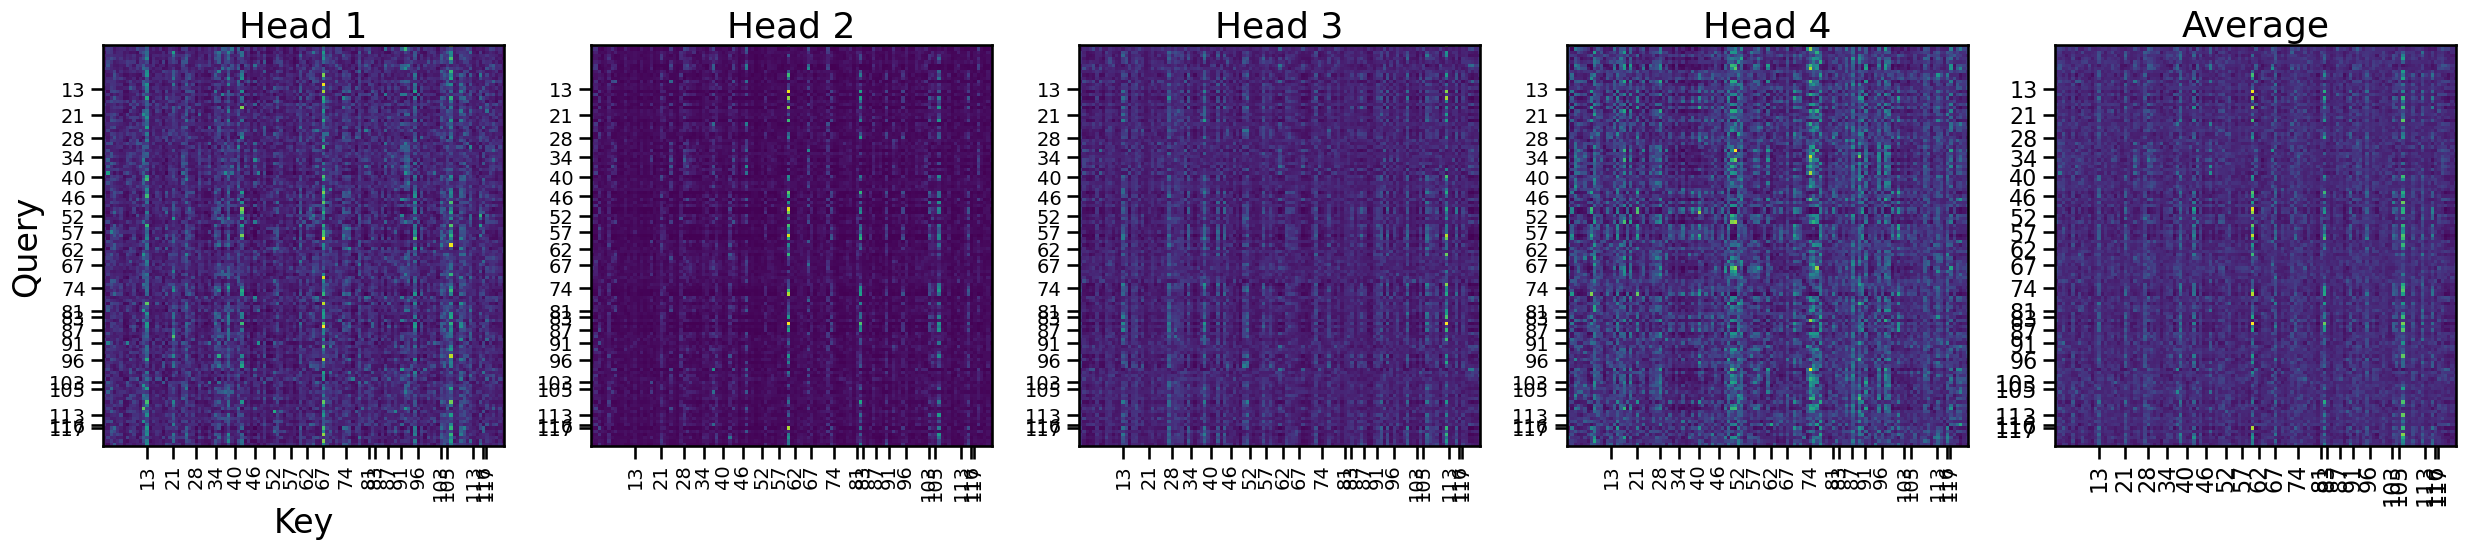


IPA391 Model Attention:


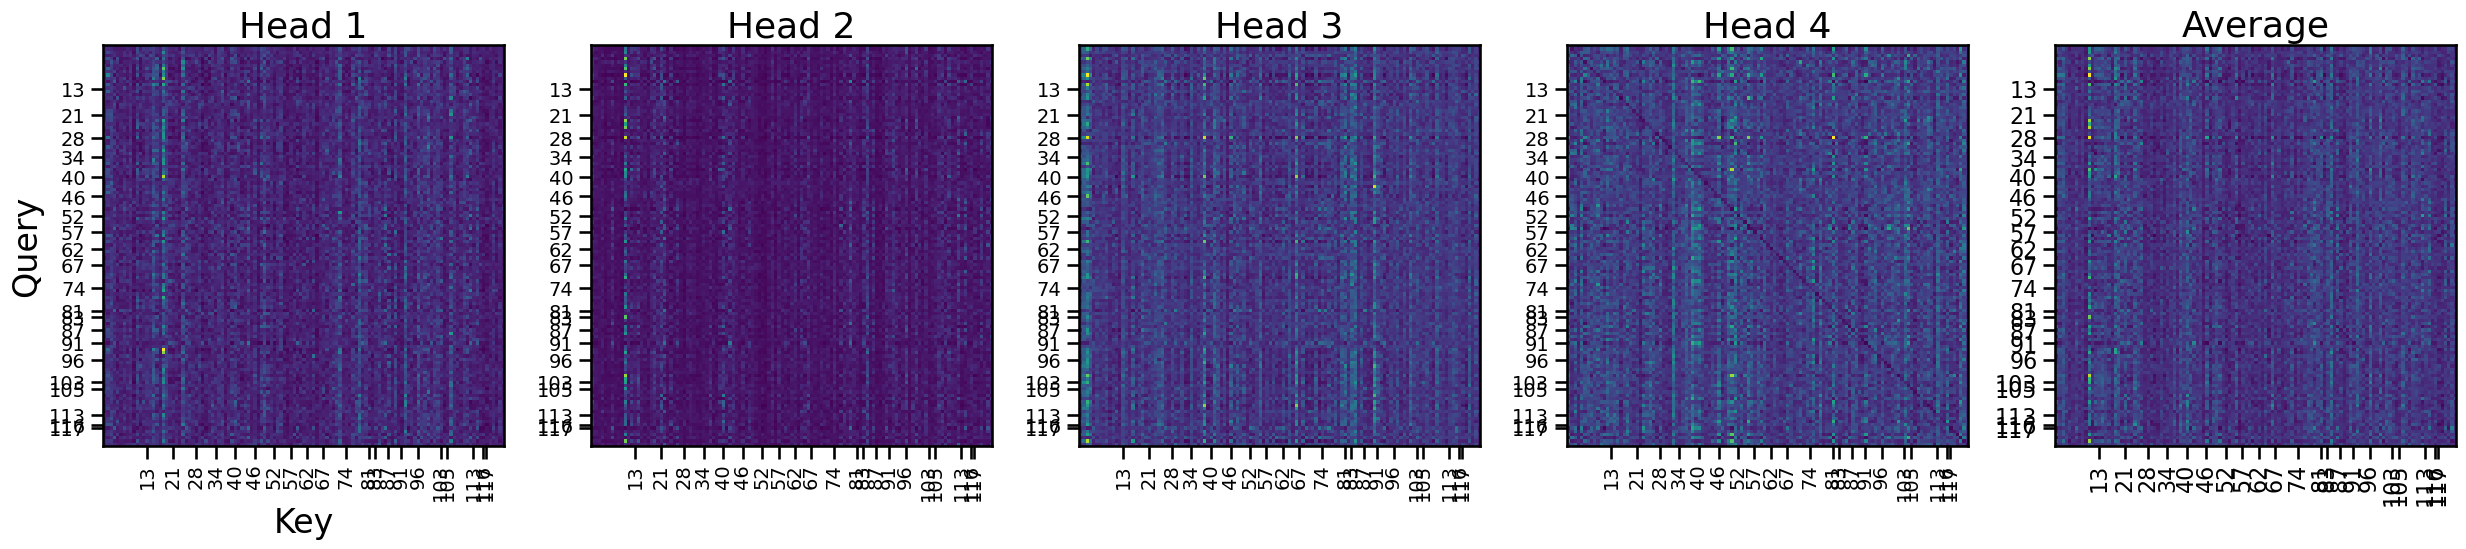

In [38]:
# Plot attention weights for UKBB model
print("UKBB Model Attention:")
plot_all_attention_heads(avg_base_smt_attn_ukbb, chrom_switches)

# Plot attention weights for IPA391 model
print("\nIPA391 Model Attention:") 
plot_all_attention_heads(avg_base_smt_attn_ipa, chrom_switches)

UKBB Model Attention with Indices:


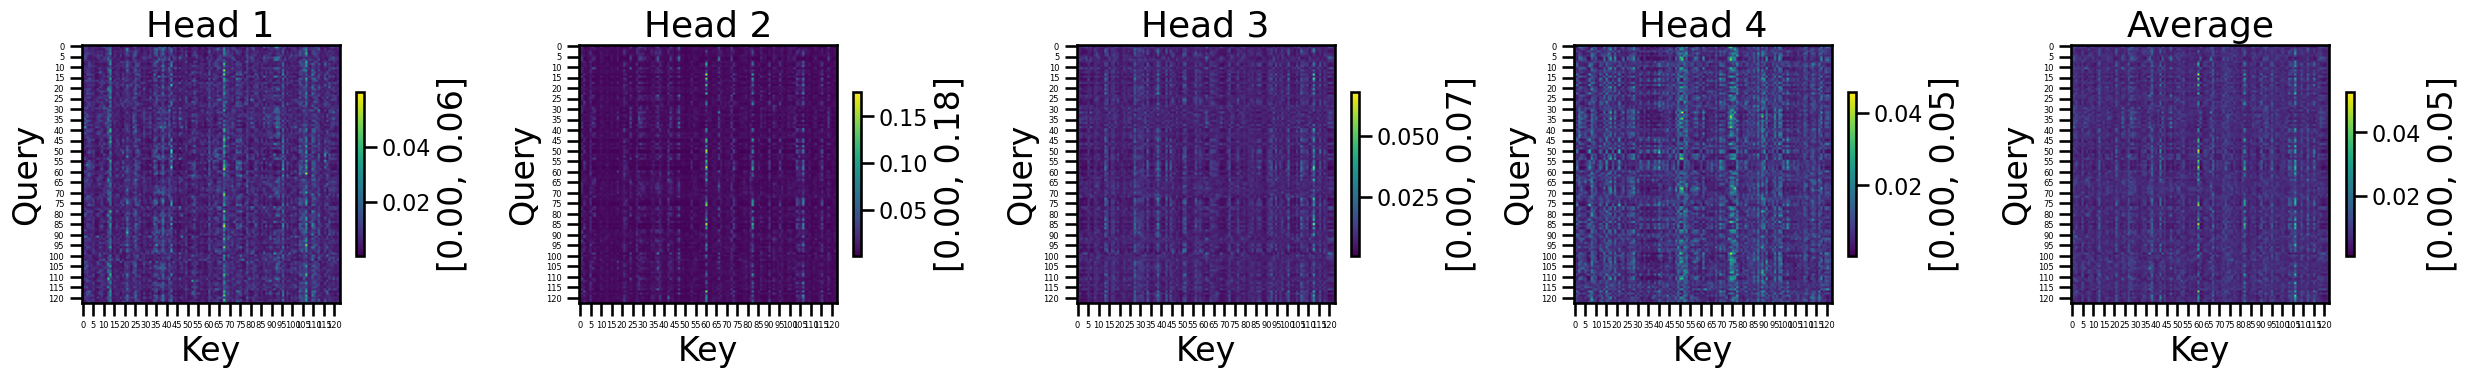


IPA391 Model Attention with Indices:


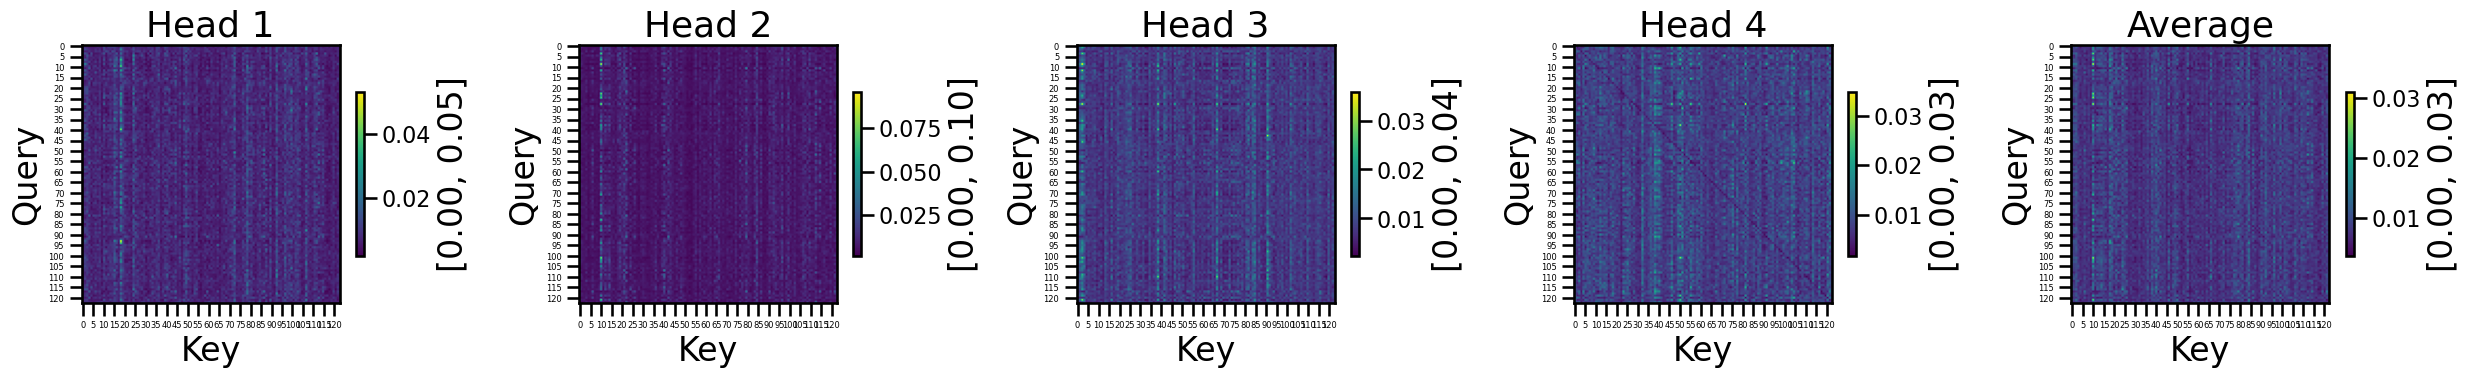

In [39]:
# Plot attention weights for UKBB model with indices
print("UKBB Model Attention with Indices:")
plot_all_attention_heads_true_ticks(avg_base_smt_attn_ukbb, chrom_switches)

# Plot attention weights for IPA391 model with indices
print("\nIPA391 Model Attention with Indices:")
plot_all_attention_heads_true_ticks(avg_base_smt_attn_ipa, chrom_switches)

UKBB Base Model Average Attention:


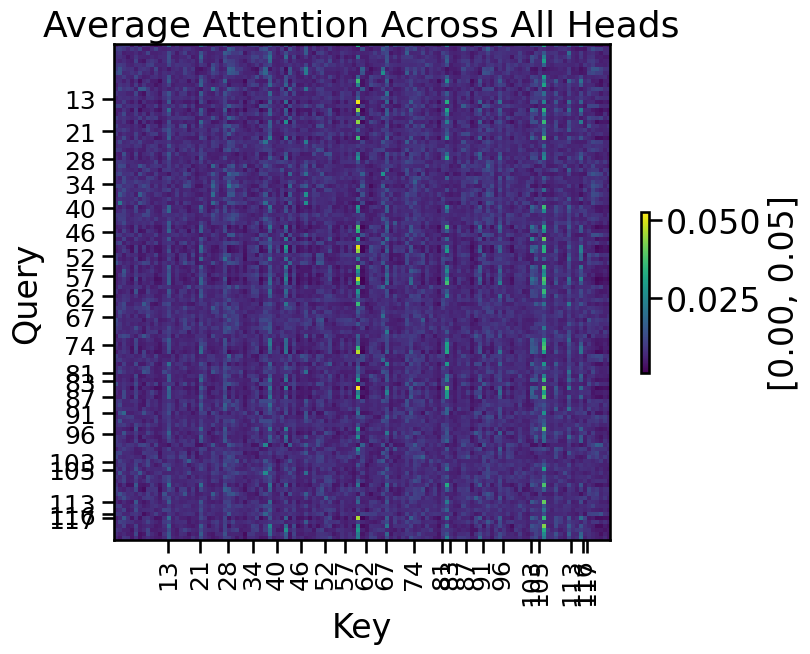


iPA391 Base Model Average Attention:


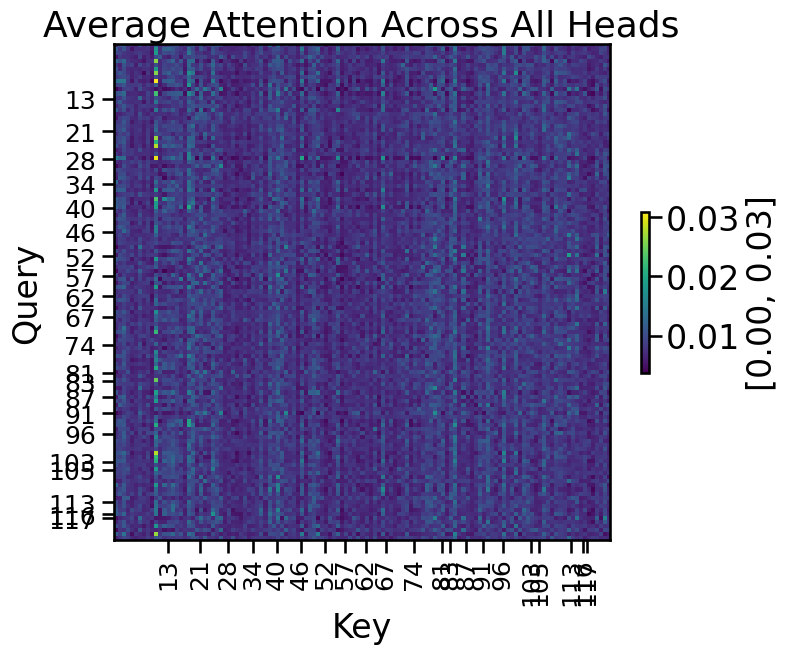

In [40]:
# Plot average attention heads separately
print("UKBB Base Model Average Attention:")
plot_average_head(avg_base_smt_attn_ukbb, chrom_switches)

print("\niPA391 Base Model Average Attention:")
plot_average_head(avg_base_smt_attn_ipa, chrom_switches)


CLS evaluation

UKBB CLS Model Attention:


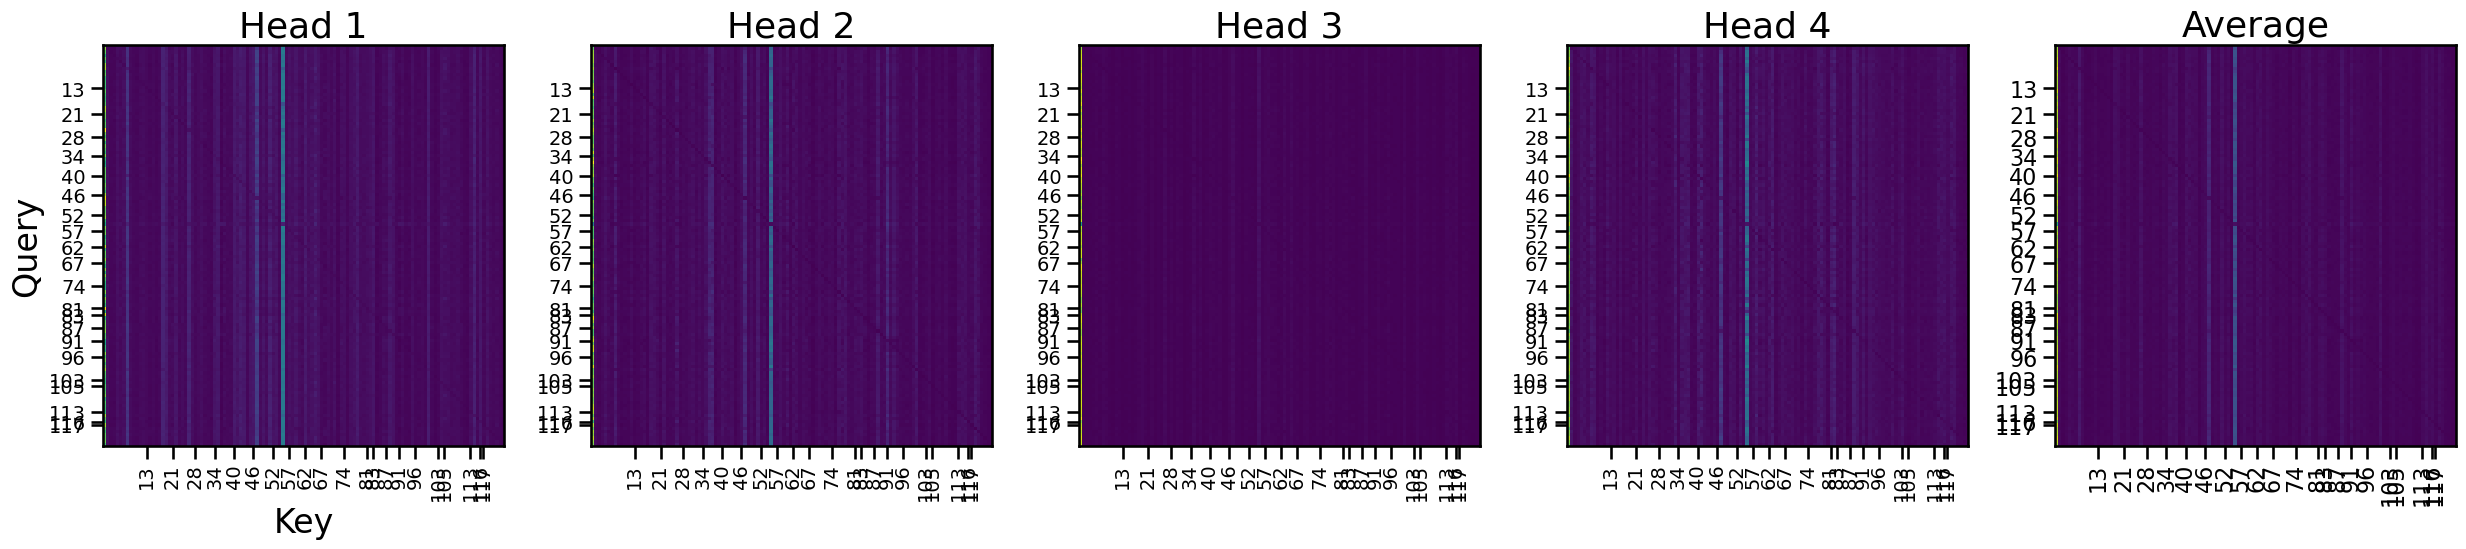


IPA391 CLS Model Attention:


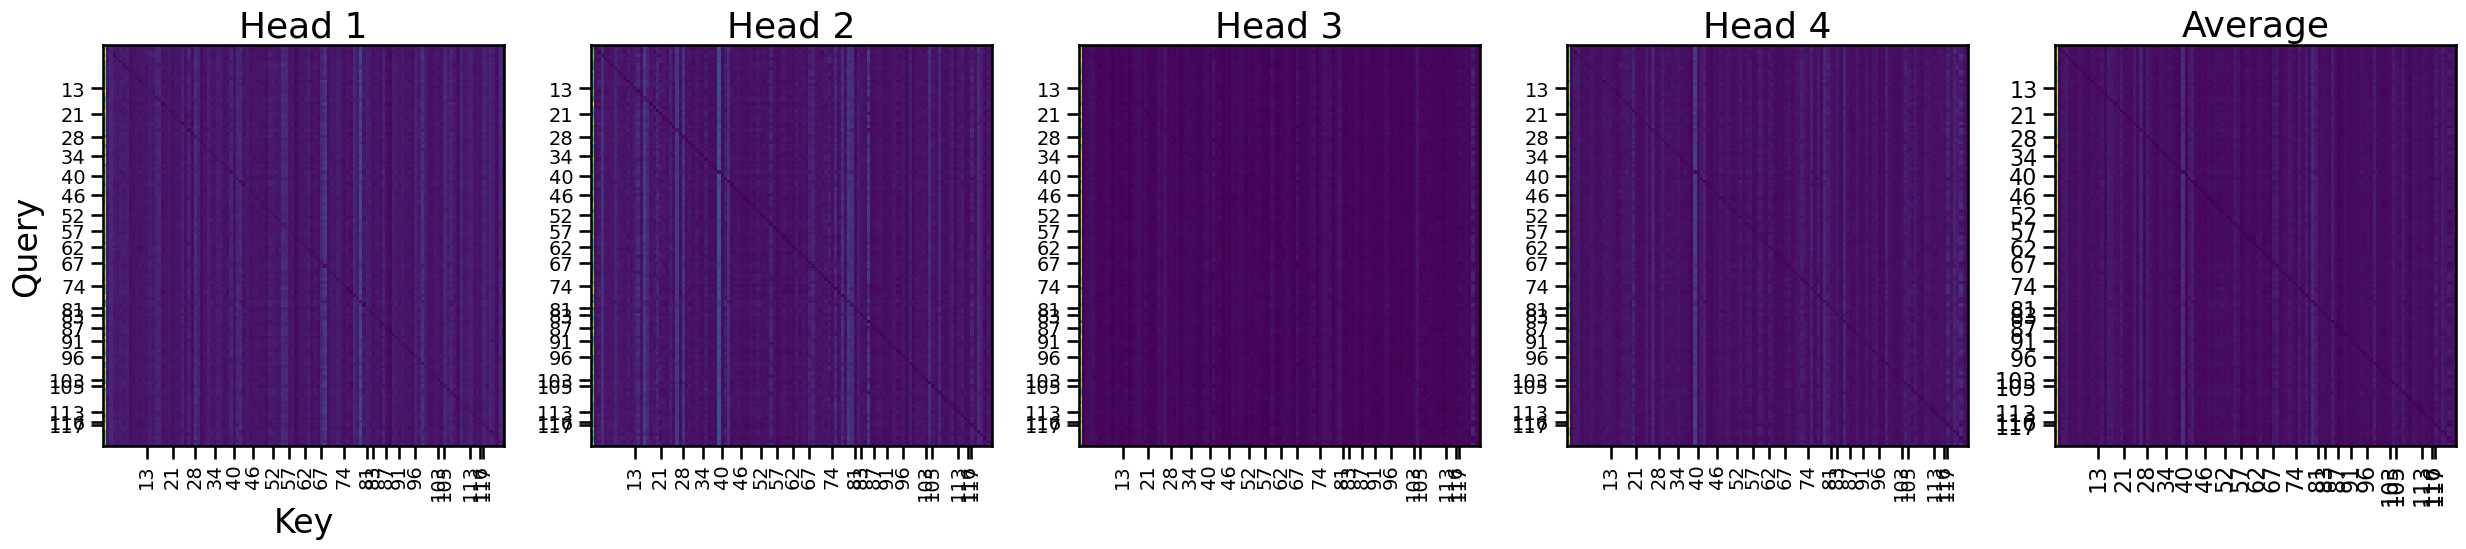

In [44]:
# Plot attention weights for UKBB CLS model
print("UKBB CLS Model Attention:")
plot_all_attention_heads(avg_smt_cls_attn_ukbb, chrom_switches)

# Plot attention weights for IPA391 CLS model
print("\nIPA391 CLS Model Attention:") 
plot_all_attention_heads(avg_smt_cls_attn_ipa, chrom_switches)

Average Attention Head:


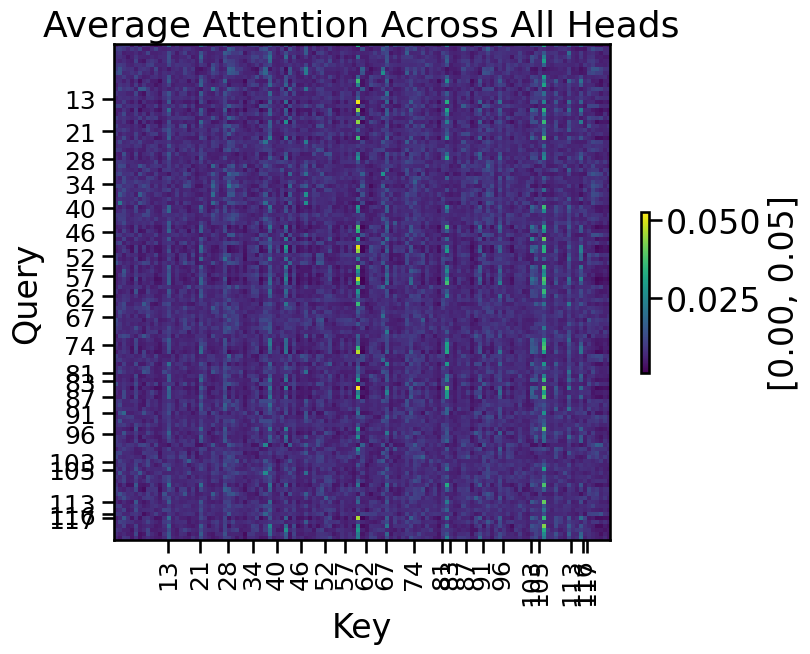


Genes in token 106:
['HSD11B1L', 'RPL36', 'LONP1', 'RFX2', 'MLLT1', 'KHSRP', 'SLC25A41', 'SLC25A23', 'DENND1C', 'C3', 'GPR108', 'VAV1', 'ZNF557', 'INSR', 'ARHGEF18', 'ZNF358', 'MCOLN1', 'CLEC4G', 'CLEC4M', 'TGFBR3L', 'CTXN1', 'TIMM44', 'ELAVL1', 'CERS4', 'KANK3', 'RAB11B', 'MYO1F', 'OR7E24', 'ZNF562', 'ZNF812P', 'FBXL12', 'UBL5', 'PIN1', 'OLFM2', 'COL5A3', 'C19orf66', 'S1PR2', 'MRPL4', 'ICAM5', 'FDX1L', 'ICAM3', 'CDC37', 'PDE4A', 'KEAP1', 'ATG4D', 'KRI1', 'CDKN2D', 'SLC44A2', 'LDLR', 'FH', 'RAB3D', 'TMEM205', 'PLPPR2', 'ELAVL3', 'ZNF653', 'ECSIT', 'CNN1', 'ELOF1', 'ZNF844', 'ZNF136']

Chromosome: NC_000019.10
HSD11B1L RPL36 LONP1 RFX2 MLLT1 KHSRP SLC25A41 SLC25A23 DENND1C C3 GPR108 VAV1 ZNF557 INSR ARHGEF18 ZNF358 MCOLN1 CLEC4G CLEC4M TGFBR3L CTXN1 TIMM44 ELAVL1 CERS4 KANK3 RAB11B MYO1F OR7E24 ZNF562 ZNF812P FBXL12 UBL5 PIN1 OLFM2 COL5A3 C19orf66 S1PR2 MRPL4 ICAM5 FDX1L ICAM3 CDC37 PDE4A KEAP1 ATG4D KRI1 CDKN2D SLC44A2 LDLR FH RAB3D TMEM205 PLPPR2 ELAVL3 ZNF653 ECSIT CNN1 ELOF1 ZNF844

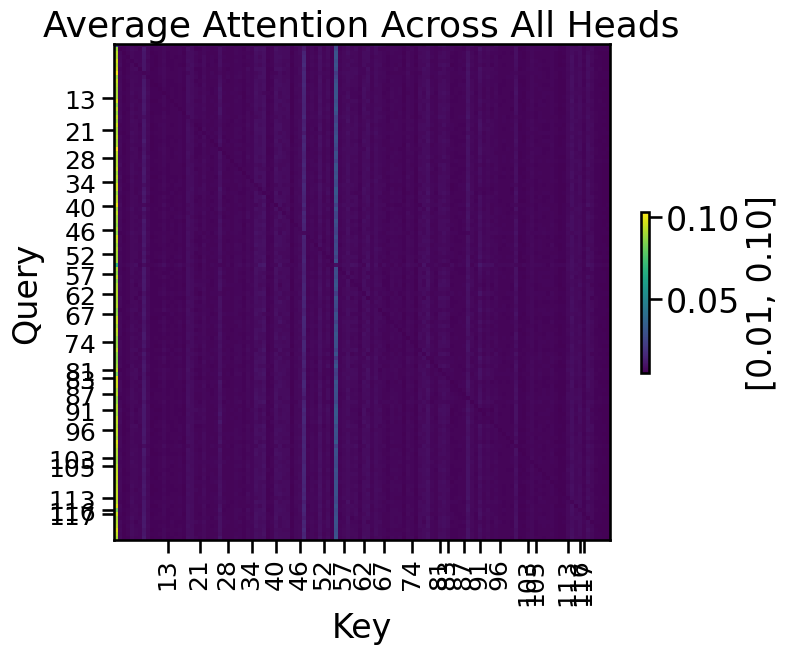


Genes in token 53:
['SFRP1', 'NKX6-3', 'ANK1', 'AP3M2', 'PLAT', 'IKBKB', 'SLC20A2', 'SMIM19', 'ASNSP1', 'SPIDR', 'SNTG1', 'RB1CC1', 'OPRK1', 'ATP6V1H', 'RGS20', 'LYPLA1', 'MRPL15', 'XKR4', 'TGS1', 'LYN', 'RPS20', 'CHCHD7', 'SDR16C5', 'PENK', 'SDCBP', 'NSMAF', 'TOX', 'CA8', 'CHD7', 'CLVS1', 'ASPH', 'NKAIN3', 'TTPA', 'MIR124-2HG', 'BHLHE22', 'CYP7B1', 'MTFR1', 'CRH', 'RRS1', 'C8orf46', 'MYBL1', 'C8orf44', 'PPP1R42', 'COPS5', 'PREX2', 'C8orf34', 'SULF1', 'LACTB2', 'XKR9', 'EYA1', 'KCNB2', 'RDH10', 'STAU2', 'UBE2W', 'ELOC', 'TMEM70', 'LY96', 'CRISPLD1', 'ZFHX4-AS1', 'ZFHX4']

Chromosome: NC_000008.11
SFRP1 NKX6-3 ANK1 AP3M2 PLAT IKBKB SLC20A2 SMIM19 ASNSP1 SPIDR SNTG1 RB1CC1 OPRK1 ATP6V1H RGS20 LYPLA1 MRPL15 XKR4 TGS1 LYN RPS20 CHCHD7 SDR16C5 PENK SDCBP NSMAF TOX CA8 CHD7 CLVS1 ASPH NKAIN3 TTPA MIR124-2HG BHLHE22 CYP7B1 MTFR1 CRH RRS1 C8orf46 MYBL1 C8orf44 PPP1R42 COPS5 PREX2 C8orf34 SULF1 LACTB2 XKR9 EYA1 KCNB2 RDH10 STAU2 UBE2W ELOC TMEM70 LY96 CRISPLD1 ZFHX4-AS1 ZFHX4
Note: Gene lists 

In [46]:
def plot_attention_and_genes(attention_weights, chrom_switches, token_idx, is_cls_model=False, gene_tokens=gene_tokens):
    """
    Plot average attention head and print genes for specified token index
    
    Args:
        attention_weights: attention weight matrix
        chrom_switches: chromosome boundary indices
        token_idx: token index to analyze
        is_cls_model: whether attention is from CLS model
        gene_tokens: dictionary mapping token indices to gene information
    """
    # Plot average attention head
    print("Average Attention Head:")
    plot_average_head(attention_weights, chrom_switches)
    
    # Adjust token index for CLS model
    print_idx = token_idx - 1 if is_cls_model else token_idx
    
    print(f"\nGenes in token {print_idx}:")
    print(gene_tokens[print_idx]['genes'])
    print("\nChromosome:", gene_tokens[print_idx]['chromosome'])
    print(' '.join(gene_tokens[print_idx]['genes']))

# Example usage:
# For base model
plot_attention_and_genes(avg_base_smt_attn_ukbb, chrom_switches, 106, is_cls_model=False)

# For CLS model  
plot_attention_and_genes(avg_smt_cls_attn_ukbb, chrom_switches, 54, is_cls_model=True)

print("Note: Gene lists for any token can be manually passed into https://biit.cs.ut.ee/gprofiler/gost for quick functional profiling")
